In [1]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image

ia.seed(1)

In [7]:
# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
# images = np.array(
#     [ia.quokka(size=(64, 64)) for _ in range(32)],
#     dtype=np.uint8
# )

im = Image.open("media/demo.jpg")
img_array = np.asarray(im)
if img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]  # Drop the last channel (alpha channel)

images = np.array([img_array]*10)

In [8]:
np.shape(images)

(10, 1024, 1024, 3)

In [9]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [10]:
images_aug = seq(images=images)

In [22]:
np.shape(images_aug)

(10, 1024, 1024, 3)

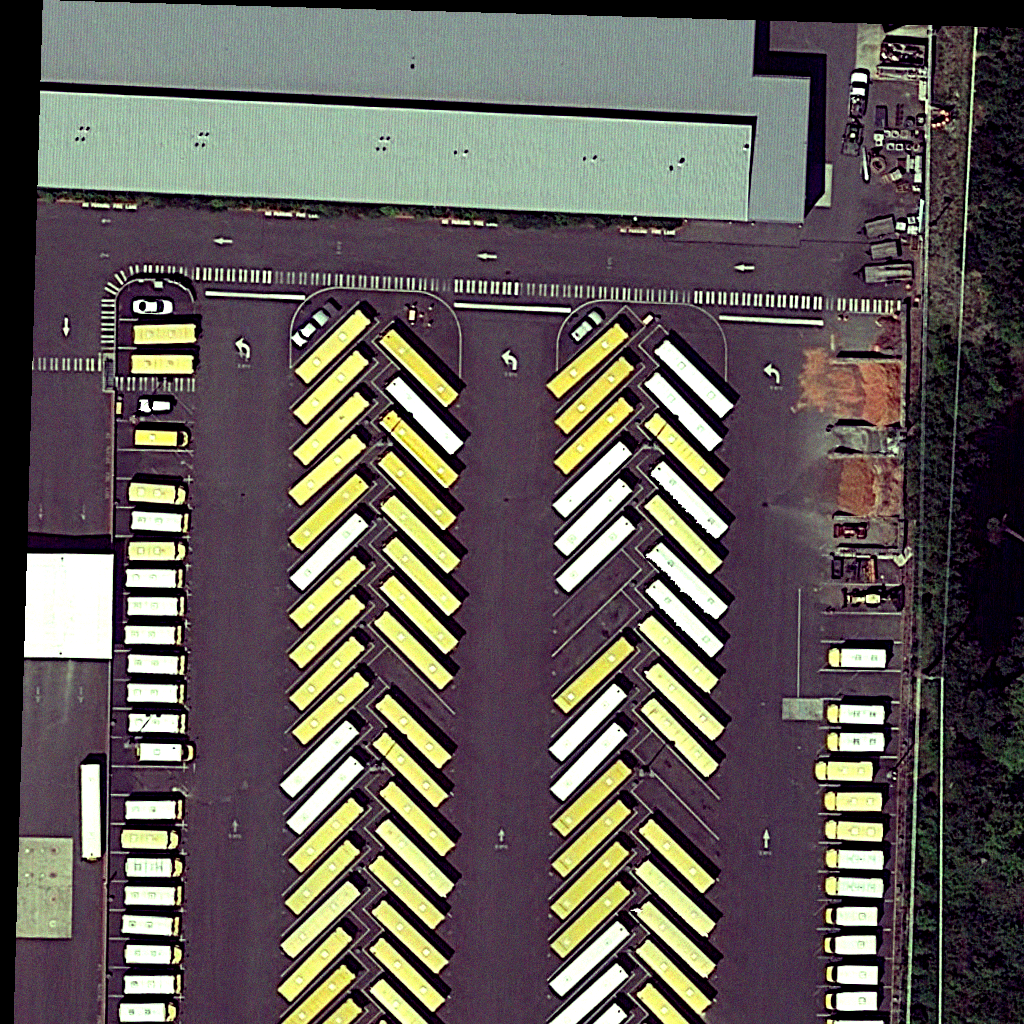

In [21]:
from PIL import Image
img = Image.fromarray(images_aug[9])
img.show()